In [1]:
import pandas as pd
import seaborn as sns
import os
import keras
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*1.Association Rule Generation from Transaction Data*

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Grocery_Items_25.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10
0,pastry,baking powder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,sausage,frozen fish,house keeping products,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ham,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,whipped/sour cream,baking powder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,house keeping products,frozen vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset.shape

(8000, 11)

In [5]:
records = []
for i in range(8000):
  records.append([str(dataset.values[i,j]) for j in range(11) if str(dataset.values[i,j]) != 'nan'])

In [6]:
encoder = TransactionEncoder()
encoder_array = encoder.fit(records).transform(records)
dataframe = pd.DataFrame(encoder_array, columns=encoder.columns_)

In [7]:
dataframe.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,bags,baking powder,bathroom cleaner,beef,berries,beverages,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


C

In [8]:
frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(soda),(other vegetables),0.103125,0.122000,0.010625,0.103030,0.844511,-0.001956,0.978851,-0.170323
1,(other vegetables),(whole milk),0.122000,0.154625,0.014250,0.116803,0.755397,-0.004614,0.957176,-0.269433
2,(rolls/buns),(whole milk),0.109625,0.154625,0.012750,0.116306,0.752178,-0.004201,0.956637,-0.270093
3,(soda),(whole milk),0.103125,0.154625,0.011875,0.115152,0.744715,-0.004071,0.955390,-0.276522
4,(yogurt),(whole milk),0.088125,0.154625,0.011375,0.129078,0.834781,-0.002251,0.970667,-0.178338


D

In [9]:
heatmap_data = []
for i in [0.001,0.005,0.01,0.05]:
    for j in [0.05,0.075,0.1]:
        frequent_itemsets = apriori(dataframe, min_support=i, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=j)
        heatmap_data.append({'msv': i, 'mct': j, 'no.of rules': len(rules)})

In [10]:
heatdata = pd.DataFrame(heatmap_data)
heatdata = heatdata.pivot(index='mct', columns='msv', values='no.of rules')

<Axes: xlabel='msv', ylabel='mct'>

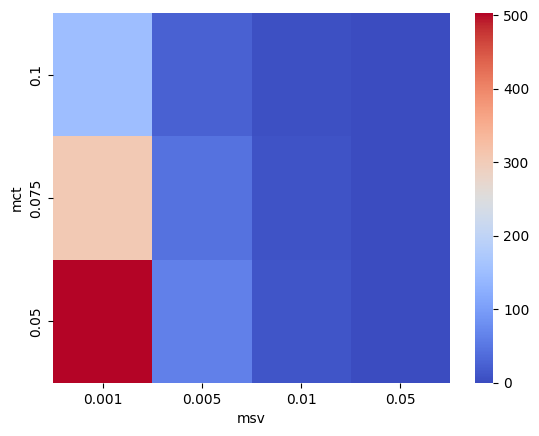

In [11]:
sns.heatmap(heatdata.sort_index(ascending=False),cmap='coolwarm')

E

In [12]:
frequent_itemsets_hc = apriori(dataframe, min_support=0.005, use_colnames=True)
rules_hc = association_rules(frequent_itemsets_hc, metric="confidence", min_threshold=0.0)
rules_hc.loc[rules_hc['confidence'].idxmax()]

antecedents           (domestic eggs)
consequents              (whole milk)
antecedent support              0.035
consequent support           0.154625
support                      0.005625
confidence                   0.160714
lift                         1.039381
leverage                     0.000213
conviction                   1.007255
zhangs_metric                0.039263
Name: 15, dtype: object

**2. Image Classification using CNN**

In [13]:
directory = "/content/drive/MyDrive/Dogs_Dataset/images_cropped"

In [14]:
Image = []
label = []
categories = sorted(os.listdir(directory))
for i in categories:
  for j in os.listdir(os.path.join(directory,i)):
    Image.append(os.path.join(directory,i,j))
    label.append(i)

In [15]:
train_data,test_data,train_label,test_label = train_test_split(Image,
                                                               label,
                                                               train_size=0.8,
                                                               random_state=10)

In [16]:
train = pd.DataFrame({'file_paths': train_data, 'labels': train_label})
test = pd.DataFrame({'file_paths': test_data, 'labels': test_label})

In [17]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(
    train,
    x_col='file_paths',
    y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
)
test_gen = datagen.flow_from_dataframe(
    test,
    x_col='file_paths',
    y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
)

Found 543 validated image filenames belonging to 4 classes.
Found 136 validated image filenames belonging to 4 classes.


In [18]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 129032)            0         
                                                                 
 dense (Dense)               (None, 16)                2064528   
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 2,064,820
Trainable params: 2,064,820
Non-trainable params: 0
______________________________________________

In [19]:
training = model.fit(train_gen,
                     validation_data = test_gen,
                    epochs = 20
                    )

Epoch 1/20
17/17 [==============================] - 108s 6s/step - loss: 3.4264 - accuracy: 0.2523 - val_loss: 1.3911 - val_accuracy: 0.2574
Epoch 2/20
17/17 [==============================] - 22s 1s/step - loss: 1.3826 - accuracy: 0.2394 - val_loss: 1.3997 - val_accuracy: 0.2426
Epoch 3/20
17/17 [==============================] - 21s 1s/step - loss: 1.3806 - accuracy: 0.2431 - val_loss: 1.3977 - val_accuracy: 0.2426
Epoch 4/20
17/17 [==============================] - 21s 1s/step - loss: 1.3781 - accuracy: 0.2449 - val_loss: 1.3985 - val_accuracy: 0.2500
Epoch 5/20
17/17 [==============================] - 22s 1s/step - loss: 1.3749 - accuracy: 0.2210 - val_loss: 1.3921 - val_accuracy: 0.2868
Epoch 6/20
17/17 [==============================] - 21s 1s/step - loss: 1.3565 - accuracy: 0.2744 - val_loss: 1.3635 - val_accuracy: 0.3382
Epoch 7/20
17/17 [==============================] - 20s 1s/step - loss: 1.2699 - accuracy: 0.4309 - val_loss: 1.2837 - val_accuracy: 0.4044
Epoch 8/20
17/17 [=

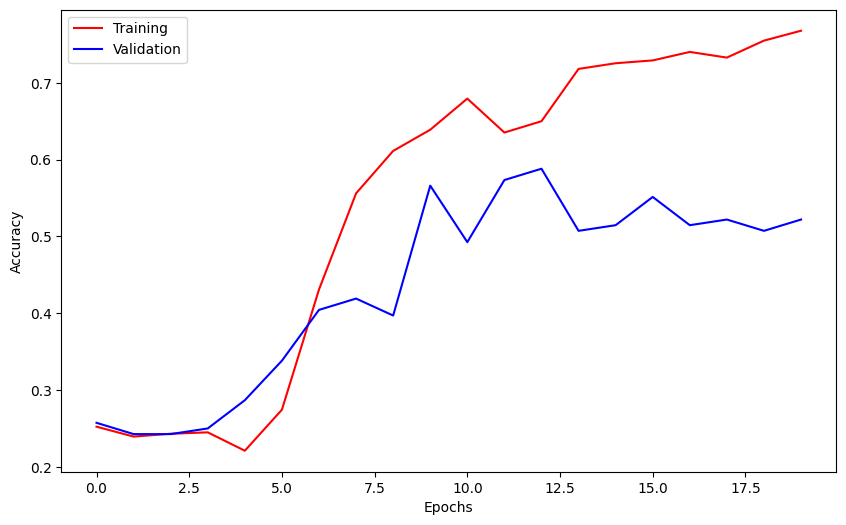

In [20]:
def plot_accuracy(train_data):
  acc = train_data.history['accuracy']
  val_acc = train_data.history['val_accuracy']

  epochs = range(len(acc))

  fig = plt.figure(figsize=(10,6))
  plt.plot(epochs,acc,c="red",label="Training")
  plt.plot(epochs,val_acc,c="blue",label="Validation")
  plt.xticks(fontsize=10)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
plot_accuracy(training)

**Rowan Banner ID - 916462027**

**Hence, C)  Train the CNN using 2 other number of nodes in the hidden layer 8 and 32 with all other
parameters unchanged**

In [22]:
model_2 = Sequential()

model_2.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256,256,3)))
model_2.add(MaxPool2D((2, 2)))
model_2.add(Flatten())
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(4, activation='softmax'))
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

training_2 = model_2.fit(train_gen,
                     validation_data = test_gen,
                    epochs = 20
                    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 129032)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1032264   
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
Total params: 1,032,524
Trainable params: 1,032,524
Non-trainable params: 0
____________________________________________

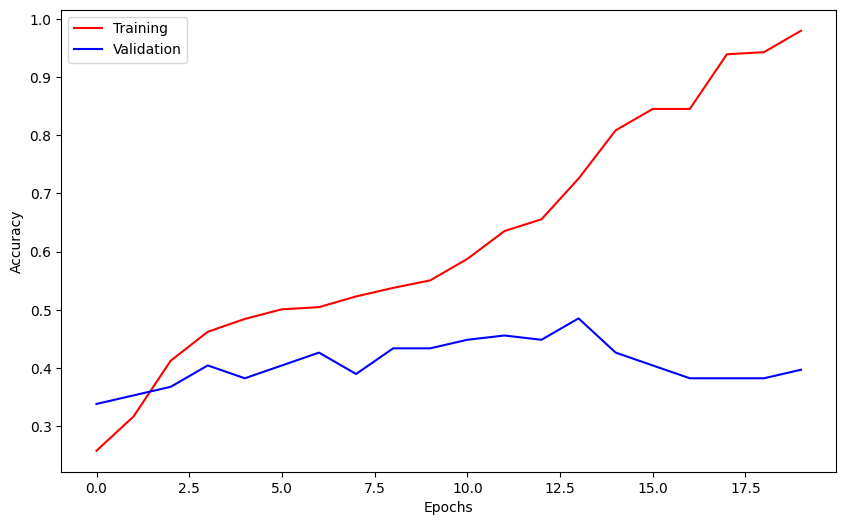

In [23]:
plot_accuracy(training_2)

In [24]:
model_3 = Sequential()

model_3.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256,256,3)))
model_3.add(MaxPool2D((2, 2)))
model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(4, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

training_3 = model_3.fit(train_gen,
                     validation_data = test_gen,
                    epochs = 20
                    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 129032)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                4129056   
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 4,129,412
Trainable params: 4,129,412
Non-trainable params: 0
____________________________________________

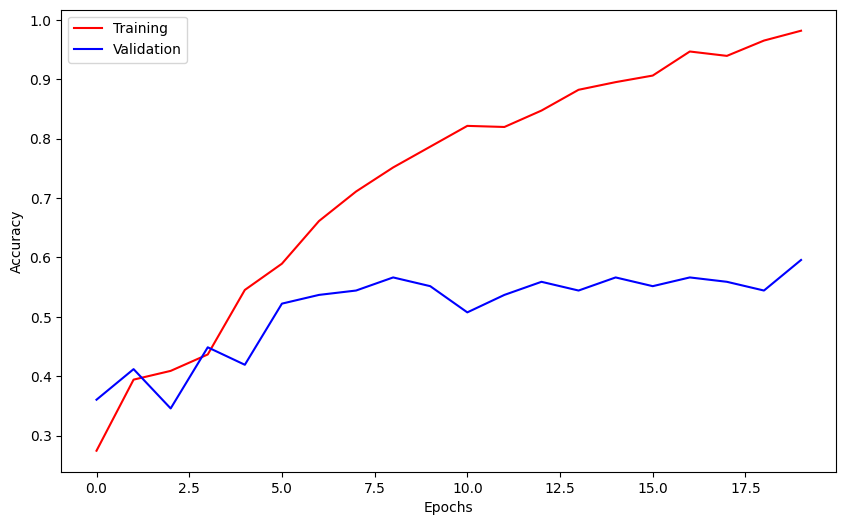

In [25]:
plot_accuracy(training_3)

From the training accuracy plots of the three models we can observe that from epoch 10 the model is starting to over-fit. The training accuacy keeps on increasing, where as the validation accuracy is starting to decrease.